In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

In [122]:
M, m = 10, 1.5
_z, _t = 0.5, 1
eps, omega, beta = 0.2, 50, 10
q1, q2 = 0.2, 0.4
pi = np.math.pi
_Bn = 1
l1, l2 = 0.6, 0.62

In [123]:
def A2(M=M, m=m):
    return 2 * pow(M, 2) / (1 + pow(m, 2))

def A(M=M, m=m):
    return np.sqrt(A2(M=M, m=m))

In [124]:
r1 = 0.5

@np.vectorize
def r2(z=_z, eps=eps):
    return 1 + eps * np.math.cos(2 * pi * z)

In [125]:
@np.vectorize
def q(t=_t, omega=omega, q1=q1, q2=q2):
    return q1 + q2 * np.math.sin(omega * t)

@np.vectorize
def dqdt(t=_t, omega=omega, q2=q2):
    return omega * q2 * np.math.cos(omega * t)

@np.vectorize
def dpdz(wr2, wr1, z=_z, t=_t, beta=beta, eps=eps, omega=omega, q1=q1, q2=q2, M=M, m=m, Bn=_Bn):
    r2_r1 = np.math.pow(r2(z=z, eps=eps), 2) - np.math.pow(r1, 2)
    
    part_1 = beta * dqdt(t=t, omega=omega, q2=q2) / (pi * r2_r1)
    part_2 = (r2_r1 / 2) + q(t=t, omega=omega, q1=q1, q2=q2) / (2 * pi)
    part_2 *= A2(M=M, m=m) / r2_r1
    part_3 = (r2(z) * wr2 - r1 * wr1) / r2_r1
    part_4 = 2 * Bn * (r2(z) - r1) / r2_r1
    return -(part_1 + part_2 - part_3 - part_4)

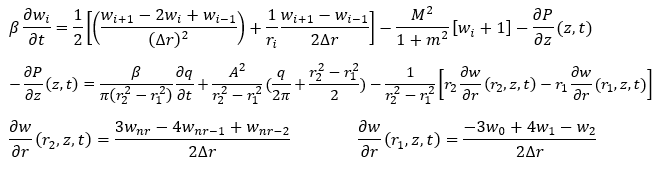

In [126]:
Image.open('newtonian-semi-discretization.png')

In [127]:
_N = 40
def rhs(w, t, N=_N, z=_z, M=M, m=m, beta=beta, eps=eps, Bn=_Bn, l1=l1, l2=l2):
    dwdt = np.zeros(N)
    w[0], w[-1] = -1, -1
    dr = (r2(z, eps) - r1) / N
    nr = N - 1
    
    # main loop
    for i in range(1, N-1):
        r = i * dr + 0.5
        
        wr1 = (-3 * w[0] + 4 * w[1] - w[2]) / (2 * dr)
        wr2 = (3 * w[nr] - 4 * w[nr - 1] + w[nr - 2]) / (2 * dr)
        part_2 = A2(M=M, m=m) * (w[i] + 1) / 2
        part_3 = dpdz(wr2, wr1, z=z, t=t, eps=eps, Bn=_Bn)
        part_4 = Bn / r
        
        dwdt[i] = - part_2 - part_3 + part_4
        
        if r >= l1 and r <= l2:
            dwdt[i] /= beta
            continue
        
        wi_p1 = w[i+1]
        wi_m1 = w[i-1]
        wr = (wi_p1 - wi_m1) / (2 * dr)
        wrr = (wi_p1 - 2 * w[i] + wi_m1) / (dr ** 2)
        part_1 = 0.5 * (wrr + wr / r)
        
        dwdt[i] += part_1
        dwdt[i] /= beta
    return dwdt

In [128]:
def solver_default(t, w):
    return rhs(w, t, N=40)

w0 = np.ones(40)
w0 *= -1

s_default = solve_ivp(solver_default, (0, 1), w0)
df_default = pd.DataFrame(s_default.y)
df_default.head(2)

,0,1,2,3,4,5,6,7,8,9,...,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069
0,-1.0,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,-1.0,-0.984852,-0.974311,-0.965596,-0.95886,-0.952836,-0.947236,-0.942117,-0.937487,-0.933271,...,-0.460966,-0.45644,-0.451692,-0.446921,-0.442373,-0.438041,-0.433682,-0.429101,-0.424392,-0.422954


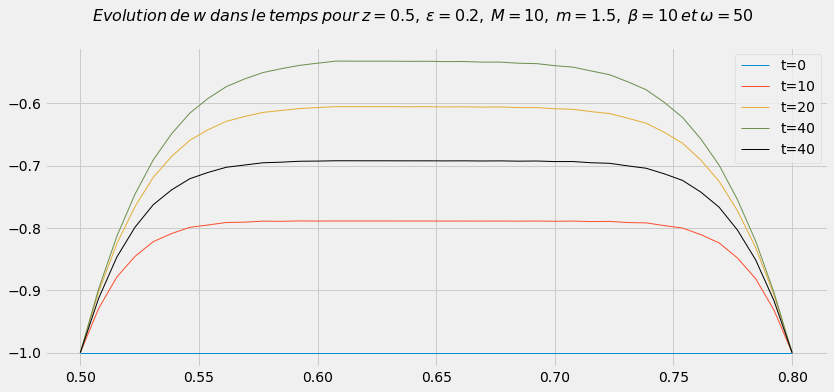

In [135]:
with plt.style.context('fivethirtyeight'):
    r_s = np.linspace(0.5, 0.8, 40)
    plt.plot(r_s, df_default.iloc[:, 0], linewidth=1, label='t=0')
    plt.plot(r_s, df_default.iloc[:, 10], linewidth=1, label='t=10')
    plt.plot(r_s, df_default.iloc[:, 20], linewidth=1, label='t=20')
    plt.plot(r_s, df_default.iloc[:, 25], linewidth=1, label='t=40')
    plt.plot(r_s, df_default.iloc[:, 15], linewidth=1, label='t=40', color='black')
    
    plt.legend()
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    sp = r'\hspace{0.2}'
    t = fr'$Evolution{sp}de{sp}w{sp}dans{sp}le{sp}temps{sp}pour{sp}z=0.5,{sp}\epsilon=0.2,{sp}M=10,{sp}m=1.5,{sp}\beta=10{sp}et{sp}\omega=50$'
    fig.suptitle(t, fontsize=16)
#     plt.savefig('figs/bingham-unsteady-time-evolution.png', transparent=True)

In [132]:
# @np.vectorize
def wr1(w_df, z=0.5, t=1):
    dr = (r2(z) - r1) / _N
    t_i = int(w_df.shape[1] * t)
    if t == 1:
        t_i -= 1
    return -3 * w_df.iloc[0, t_i] + 4 * w_df.iloc[1, t_i] - w_df.iloc[2, t_i] / (2 * dr)

# @np.vectorize
def wr2(w_df, z=0.5, t=1):
    dr = (r2(z) - r1) / _N
    nr = _N - 1
    t_i = int(w_df.shape[1] * t)
    if t == 1:
        t_i -= 1
    return -3 * w_df.iloc[nr, t_i] + 4 * w_df.iloc[nr-1, t_i] - w_df.iloc[nr-2, t_i] / (2 * dr)

zs = np.linspace(0, 1, 5)
ts = np.linspace(0, 1, 200)
dpdz_1 = np.zeros((5, 200))
for i in range(5):
    for j in range(200):
        w1 = wr1(df_default, z=zs[i], t=ts[j])
        w2 = wr2(df_default, z=zs[i], t=ts[j])
        dpdz_1[i, j] = dpdz(w2, w1, z=zs[i], t=ts[j])

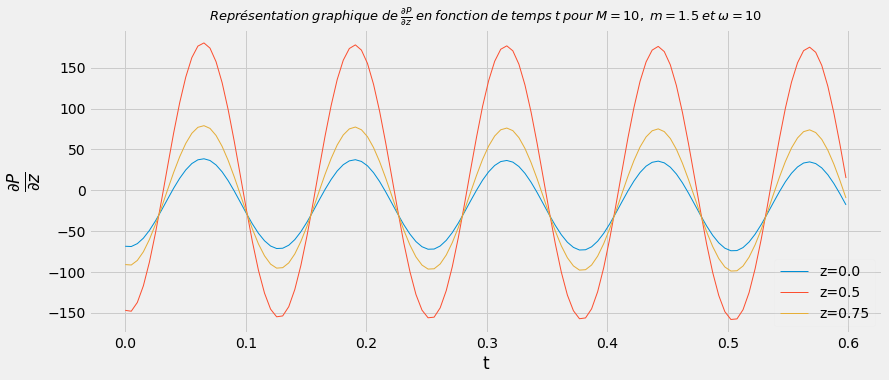

In [133]:
with plt.style.context('fivethirtyeight'):
    frac = r'\frac{\partial P}{\partial z}'
    sp = r'\hspace{0.25}'
    t = fr'$Représentation{sp}graphique{sp}de{sp}{frac}{sp}en{sp}fonction{sp}de{sp}temps{sp}t{sp}pour{sp}M=10,{sp}m=1.5{sp}et{sp}\omega=10$'
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.title(t, fontsize=13)
    
    plt.xlabel('t')
    plt.ylabel(f'${frac}$', fontsize=24)
    
    plt.tight_layout()
    
    plt.plot(ts[:120], dpdz_1[0, :120], linewidth=1, label=f'z={zs[0]}')
#     plt.plot(ts[:120], dpdz_2[1, :120], linewidth=1, label=f'z={zs[1]}')
    plt.plot(ts[:120], dpdz_1[2, :120], linewidth=1, label=f'z={zs[2]}')
    plt.plot(ts[:120], dpdz_1[3, :120], linewidth=1, label=f'z={zs[3]}')
    plt.legend(framealpha=0.1)
    
#     plt.savefig('bingham-unsteady-pressure-gradient.png', transparent=True)